## Test de CNN cardIAc

- suit l'article donné en documentation

In [3]:
import tensorflow as tf
import numpy as np
import numpy as np                   # For numerical operations (if needed for data manipulation)
import tensorflow as tf              # To build and train the model
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input  # Layers used in the model
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels (if applicable)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

from easydict import EasyDict

In [5]:
path_to_datasets = "../neural_network/dataset_publications/datas/train_data"

# Training data
train_X_val = np.load(f"{path_to_datasets}/X.npy")

print(train_X_val.shape)

train_X_signal = train_X_val[::,:-2] # remove frequency at the end to get a good looking signal
train_X_freq = train_X_val[::,-2:] # frequency handled separately
print("train_X_signal shape :", train_X_signal.shape)

train_Y_temp = np.load(f"{path_to_datasets}/y_train.npy")
print("train_Y_temp shape :", train_Y_temp.shape)

# Test data
test_X_PCA = np.load(f"{path_to_datasets}/X_test.npy")
test_Y_temp = np.load(f"{path_to_datasets}/y_test.npy")


(5000, 183)
train_X_signal shape : (5000, 181)
train_Y_temp shape : (5000,)


In [6]:
# Vectorize Y for training and test
# Classes :
# - [0] : 'A' (Atrial premature contraction)
# - [1] : 'L' (Left bundle branch block fluctuation)
# - [2] : 'N' (Normal)
# - [3] : 'R' (Right bundle branch block fluctuation)
# - [4] : 'V' (premature ventricular contraction)

def vectorize_Y(arr):
    mapping = {'A': [1, 0, 0, 0, 0],
               'L': [0, 1, 0, 0, 0],
               'N': [0, 0, 1, 0, 0],
               'R': [0, 0, 0, 1, 0],
               'V': [0, 0, 0, 0, 1]}
    
    res = np.array([mapping[val] for val in arr])
    return res

def devectorize_Y(vectorized_arr):
    mapping = {(1, 0, 0, 0, 0): 'A',
               (0, 1, 0, 0, 0): 'L',
               (0, 0, 1, 0, 0): 'N',
               (0, 0, 0, 1, 0): 'R',
               (0, 0, 0, 0, 1): 'V'}
    res = np.array([mapping[tuple(vec)] for vec in vectorized_arr])
    return res

# Vectorize train and test data
train_Y = vectorize_Y(train_Y_temp)
test_Y = vectorize_Y(test_Y_temp)


# CNN 

In [7]:
# Split train / test

X_train, X_val, Y_train, Y_val = train_test_split(train_X_signal, train_Y, test_size=0.2, random_state=42)

np.save('data/X_train.npy', X_train)
np.save('data/Y_train.npy', Y_train)
np.save('data/X_val.npy', X_val)
np.save('data/Y_val.npy', Y_val)

In [8]:
# CNN Layers
# 2 inputs : signal and time between beats

signal_size = train_X_signal.shape
print("signal size :", signal_size)

# Create the model
model = Sequential()

# Input shape = (256, 1), filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu', input_shape=(181, 1)))

# Pooling size chosen to reach 86, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu'))

# Pooling size chosen to reach 29, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Flatten the output to connect with the fully connected layer
model.add(Flatten())

# Small layers at the output
model.add(Dense(units=32, activation='relu'))

# Input size = 116 (29x4 after Flatten), output size = 5
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


signal size : (5000, 181)


c:\Users\kezia\Documents\cardIAc\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 161, 4)         │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 53, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 33, 4)          │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033 (7.94 KB)

 Trainable params: 2,033 (7.94 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement simple

(5000, 5)
Epoch 1/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3630 - loss: 1.5010 - val_accuracy: 0.7100 - val_loss: 0.8539
Epoch 2/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7298 - loss: 0.7919 - val_accuracy: 0.7880 - val_loss: 0.6299
Epoch 3/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.6126 - val_accuracy: 0.8250 - val_loss: 0.5102
Epoch 4/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8224 - loss: 0.5176 - val_accuracy: 0.8430 - val_loss: 0.4418
Epoch 5/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8395 - loss: 0.4719 - val_accuracy: 0.8750 - val_loss: 0.4113
Epoch 6/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - loss: 0.3980 - val_accuracy: 0.8800 - val_loss: 0.3800
Epoch 7/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - loss: 0.3864 - val_accuracy: 0.8900 - val_loss: 0.3379
Epoch 8/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8854 - loss: 0.3416 - val_accuracy: 0.8920 -

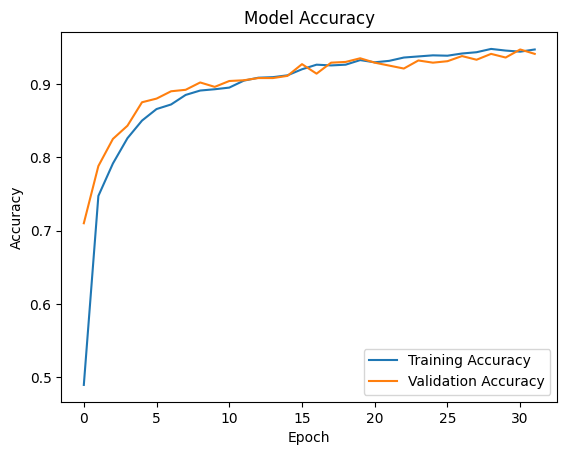

In [ ]:
# Compile and train the model

print(train_Y.shape)

# Metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name="train_loss")
train_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

optimizer = Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, 
    Y_train, 
    epochs=32, 
    batch_size=50, 
    validation_data=(X_val, Y_val)  # Use validation_data instead of validation_split
)

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### Entraînement avec protection contre adversarial

Epoch 1/32
Loss: 1.0295, Accuracy: 0.6395, Val Loss: 0.7929, Val Accuracy: 0.7470
Epoch 2/32
Loss: 0.8028, Accuracy: 0.7326, Val Loss: 0.6801, Val Accuracy: 0.7960
Epoch 3/32
Loss: 0.7020, Accuracy: 0.7717, Val Loss: 0.6113, Val Accuracy: 0.8100
Epoch 4/32
Loss: 0.6432, Accuracy: 0.7843, Val Loss: 0.5658, Val Accuracy: 0.8260
Epoch 5/32
Loss: 0.6006, Accuracy: 0.7975, Val Loss: 0.5279, Val Accuracy: 0.8240
Epoch 6/32
Loss: 0.5677, Accuracy: 0.8022, Val Loss: 0.5009, Val Accuracy: 0.8350
Epoch 7/32
Loss: 0.5391, Accuracy: 0.8092, Val Loss: 0.4800, Val Accuracy: 0.8500
Epoch 8/32
Loss: 0.5186, Accuracy: 0.8199, Val Loss: 0.4599, Val Accuracy: 0.8550
Epoch 9/32
Loss: 0.5020, Accuracy: 0.8262, Val Loss: 0.4457, Val Accuracy: 0.8650
Epoch 10/32
Loss: 0.4898, Accuracy: 0.8328, Val Loss: 0.4348, Val Accuracy: 0.8650
Epoch 11/32
Loss: 0.4778, Accuracy: 0.8360, Val Loss: 0.4226, Val Accuracy: 0.8720
Epoch 12/32
Loss: 0.4645, Accuracy: 0.8418, Val Loss: 0.4120, Val Accuracy: 0.8780
Epoch 13/32
L

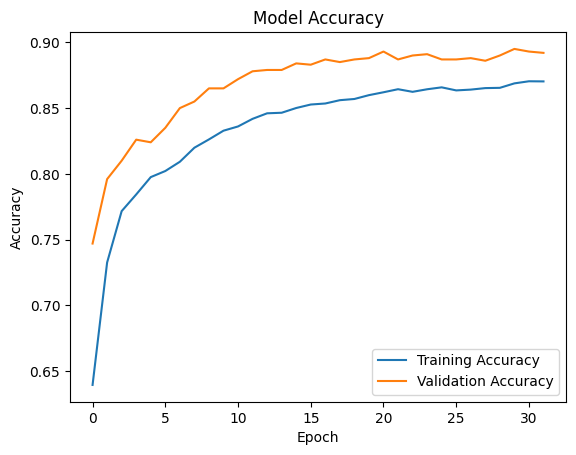

In [10]:
# Define function to generate adversarial examples
def generate_adversarial_batch(model, x, y, epsilon=0.1, alpha=0.01, iterations=10):
    """
    Generate adversarial examples using PGD for a batch of samples.

    Args:
    - model: Trained model.
    - x: Input samples.
    - y: True labels.
    - epsilon: Maximum perturbation size.
    - alpha: Step size per iteration.
    - iterations: Number of attack iterations.

    Returns:
    - x_adv: Adversarial examples.
    """
    x_adv = projected_gradient_descent(model, x, eps=epsilon, eps_iter=alpha, nb_iter=iterations, norm=np.inf)
    return x_adv

# Custom training loop with adversarial examples
batch_size = 50
epochs = 32
epsilon = 0.1  # Perturbation size for adversarial examples
alpha = 0.01  # Step size
iterations = 10  # Number of attack iterations

num_batches = len(X_train) // batch_size
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    epoch_acc = 0

    for batch in range(num_batches):
        # Select a batch of samples
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        x_batch = X_train[start_idx:end_idx]
        y_batch = Y_train[start_idx:end_idx]

        # Generate adversarial examples for a small subset of the batch
        adv_sample_count = int(0.1 * batch_size)  # 10% of the batch size
        x_adv_batch = generate_adversarial_batch(
            model, x_batch[:adv_sample_count], y_batch[:adv_sample_count], epsilon, alpha, iterations
        )

        # Combine adversarial and clean examples
        x_combined = np.vstack([x_batch, x_adv_batch])
        y_combined = np.vstack([y_batch, y_batch[:adv_sample_count]])

        # Train on this combined batch
        metrics = model.train_on_batch(x_combined, y_combined)

        epoch_loss += metrics[0]
        epoch_acc += metrics[1]

    # Evaluate on validation data
    val_metrics = model.evaluate(X_val, Y_val, verbose=0)

    # Record metrics
    history['loss'].append(epoch_loss / num_batches)
    history['accuracy'].append(epoch_acc / num_batches)
    history['val_loss'].append(val_metrics[0])
    history['val_accuracy'].append(val_metrics[1])

    print(f"Loss: {epoch_loss / num_batches:.4f}, Accuracy: {epoch_acc / num_batches:.4f}, "
          f"Val Loss: {val_metrics[0]:.4f}, Val Accuracy: {val_metrics[1]:.4f}")

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy on adversarial examples : 0.80


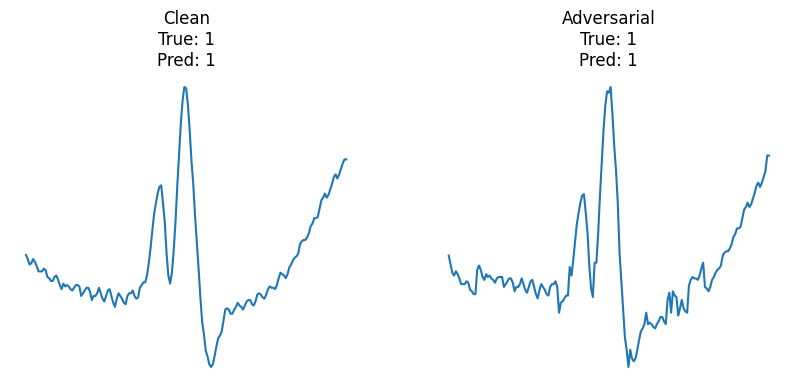

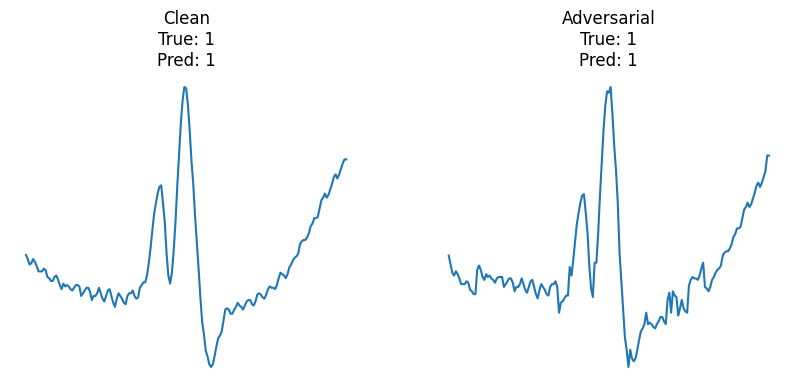

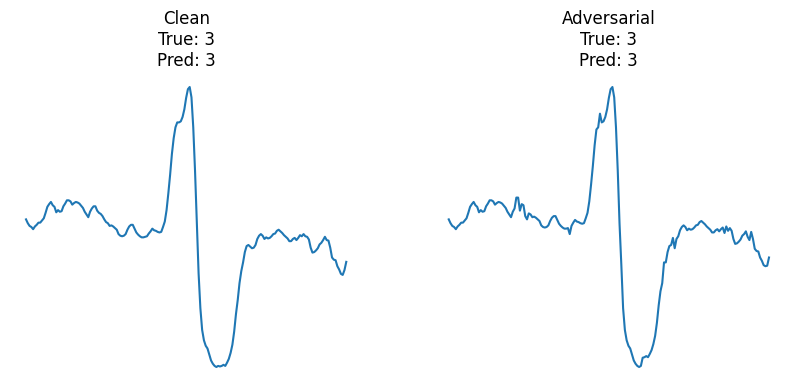

In [12]:
# Variables
nb_epochs=10
adv_perturbation_budget=0.04
pgd_iterations=40
pgd_step_budget=0.005

def plot_comparison_pgd(x_clean, x_adv, y_true, y_pred_clean, y_pred_adv, n_samples):
    """
    Plot clean and adversarial examples with predictions (PGD).
    
    Args:
    - x_clean: Clean input samples.
    - x_adv: Adversarial examples.
    - y_true: True labels.
    - y_pred_clean: Predictions on clean samples.
    - y_pred_adv: Predictions on adversarial examples.
    - n_samples: Number of samples to display.
    """
    for j in range(3):
        i = random.randint(0, n_samples)
        plt.figure(figsize=(10, 4))
        
        # Clean image
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(0, train_X_signal.shape[1]), x_clean[i])
        plt.title(f"Clean\nTrue: {np.argmax(y_true[i])}\nPred: {np.argmax(y_pred_clean[i])}")
        plt.axis("off")
        
        # Adversarial image
        plt.subplot(1, 2, 2)
       # plt.show(x_adv[i].reshape(181, 1), cmap='gray')
        plt.plot(np.arange(0, train_X_signal.shape[1]), x_adv[i])
        plt.title(f"Adversarial\nTrue: {np.argmax(y_true[i])}\nPred: {np.argmax(y_pred_adv[i])}")
        plt.axis("off")
        
        plt.show()

#ATTACKS WITH FGSM - is bad
# x_fgm = fast_gradient_method(model, x, adv_perturbation_budget, np.inf)
# y_pred_fgm = model(x_fgm)
# test_acc_fgsm(y, y_pred_fgm)

#ATTACKS WITH PGD (iterative attack)
x_pgd = projected_gradient_descent(model, X_val, adv_perturbation_budget, pgd_step_budget, pgd_iterations, np.inf)
y_pred_pgd = model(x_pgd)

# Predictions on clean and adversarial examples
y_pred_clean = model.predict(X_val)
y_pred_adv_pgd = model.predict(x_pgd)

# Evaluate model on adversarial examples
loss, accuracy = model.evaluate(x_pgd, Y_val, verbose=0)
print(f"Accuracy on adversarial examples : {accuracy:.2f}")

plot_comparison_pgd(X_val, x_pgd, Y_val, y_pred_clean, y_pred_adv_pgd, n_samples=50)